In [ ]:
# Notebook to generate thumbnails on micrographs from EMPIAR-10426 (AcrB) and EMPIAR-11637 (CI)

In [42]:
# Import packages
from vesicle_picker import (
    preprocess,
    generate_masks,
    postprocess,
    helpers,
    external_import,
    external_export,
    funcs_mrcio
)
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from skimage import filters
from cryosparc.tools import downsample

In [2]:
# Define an import function
def import_mrc(filename):
    """Use funcs_mrcio to open a specified .mrc file"""
    # Read the .mrc file in binary
    micrograph = open(filename, 'rb')

    # Use funcs_mrcio to extract image array and
    # rescale values to lie between [-1, 1]
    image = funcs_mrcio.irdsec_opened(micrograph, 0)

    # Use funcs_mrcio to extract header info
    header = funcs_mrcio.irdhdr_opened(micrograph)

    # Return the rescaled image and header
    return image, header

In [12]:
# Import the example mrc
image_fullres, header = import_mrc("EMPIAR-10426/motioncorrected/001279563948633455632_stack_2nd_0102_patch_aligned.mrc")

In [40]:
# Use the preprocess module to get micrograph ready for segmentation
preprocessed_micrograph = preprocess.preprocess_micrograph(
    image_fullres,
    downsample=4,
    lowpass_mode="bilateral",
    d=17,
    sigmaColor=71,
    sigmaSpace=71
)

(-0.5, 7675.5, 7419.5, -0.5)

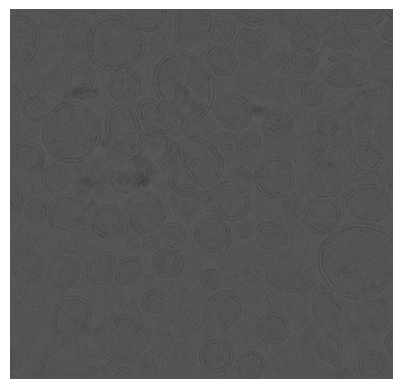

In [41]:
# Display the preprocessed micrograph
plt.imshow(preprocessed_micrograph, cmap="Greys_r")
plt.axis('off')

In [17]:
# Initialize the model
model = generate_masks.initialize_model(
    model_weights_path="./sam_vit_h_4b8939.pth",
    device='cuda:0'
)

In [24]:
# Generate masks with user-optimized parameters
masks = generate_masks.generate_masks(
    preprocessed_micrograph,
    model,
    points_per_side=36,
    points_per_batch=16,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    crop_nms_thresh=0.3,
    min_mask_region_area=100,
    psize=1.07,
    downsample=4
)

In [25]:
# Use the postprocess module to compute statistics on the vesicles
postprocessed_masks = postprocess.postprocess_masks(
    masks,
    [
        postprocess.find_mask_intensity,
        postprocess.find_contour,
        postprocess.find_roundness,
        postprocess.fit_ellipse
    ],
    preprocessed_micrograph
)

In [26]:
# Filter these vesicles based on min and max values recorded in 'filters.ini'
filtered_masks = postprocess.apply_filters(postprocessed_masks, "tests/filters.ini")

# Use the extract_statistics function to generate Pandas Dataframes
# of the postprocessed values, for downstream analysis.
unfiltered_dataset, filtered_dataset = (
    postprocess.extract_statistics(postprocessed_masks, "tests/filters.ini")
)

pd.DataFrame(filtered_dataset)

,area,roundness
0,71646,0.895610
1,22748,0.890746
2,29070,0.887773
3,34450,0.715979
4,36605,0.881734
...,...,...
80,9987,0.727635
81,41988,0.740250
82,46951,0.706314
83,108065,0.855058


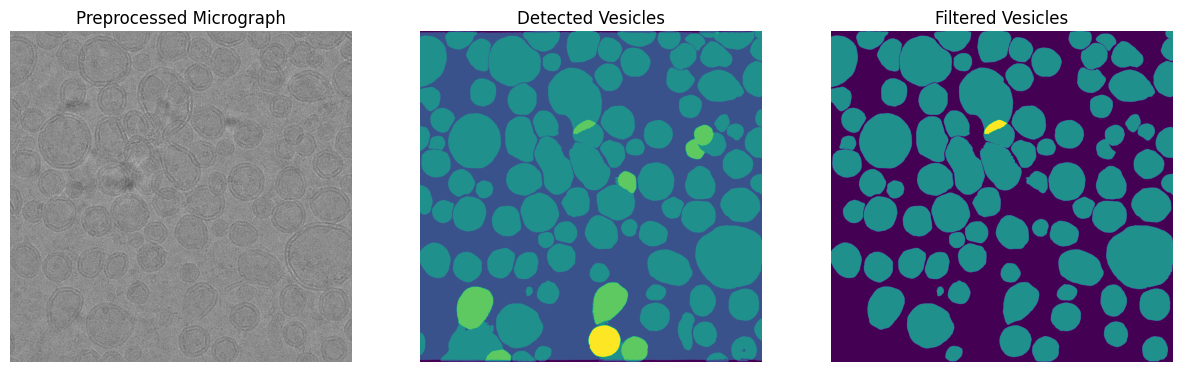

In [27]:
# Create a figure with three subplots arranged in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image in the first subplot
axes[0].imshow(preprocessed_micrograph, cmap="Greys_r")
axes[0].set_title('Preprocessed Micrograph')

# Plot the second image in the second subplot
axes[1].imshow(helpers.sum_masks(masks, 'segmentation'))
axes[1].set_title('Detected Vesicles')

# # Plot the third image in the third subplot
axes[2].imshow(helpers.sum_masks(filtered_masks, 'segmentation'))
axes[2].set_title('Filtered Vesicles')

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

In [32]:
# Once you have a set of filters you like, generate the picks
pick_indices = postprocess.generate_picks(
    filtered_masks,
    psize=1.03,
    downsample=4,
    box_size=150,
    mode='edge'
)

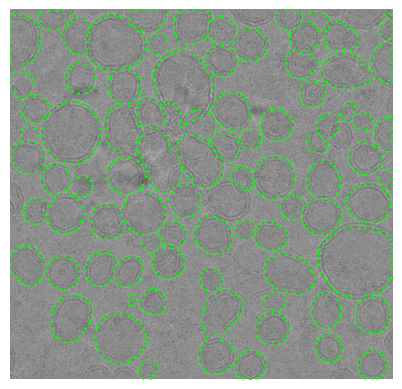

In [33]:
# Plot the preprocessed micrograph with picks overlaid
plot_micrograph = preprocess.preprocess_micrograph(
    image_fullres,
    downsample=4,
    lowpass_mode="bilateral",
    d=11,
    sigmaColor=71,
    sigmaSpace=71
)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(plot_micrograph, cmap="Greys_r")

# Overlay the undilated picks
ax1.scatter(x=pick_indices[1]/4,
            y=pick_indices[0]/4,
            marker='x',
            color='lime',
            s=1,
            label='original')

plt.axis('off')
plt.show()

In [ ]:
# Now save a Gaussian-blurred display micrograph, the micrograph with annotations overlayed, and the micrograph with picks overlayed

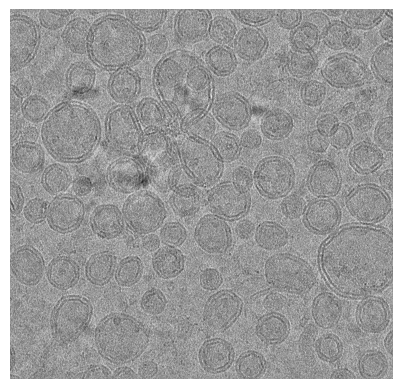

In [55]:
# Display micrograph
display_micrograph = filters.gaussian(image_fullres,3)
plt.imshow(display_micrograph, cmap="Greys_r")
plt.axis('off')

plt.savefig("EMPIAR-10426/figures/001279563948633455632_raw.png", dpi=600, bbox_inches="tight", pad_inches=0)


plt.show()

In [50]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.4]])
        img[m] = color_mask
    ax.imshow(img)

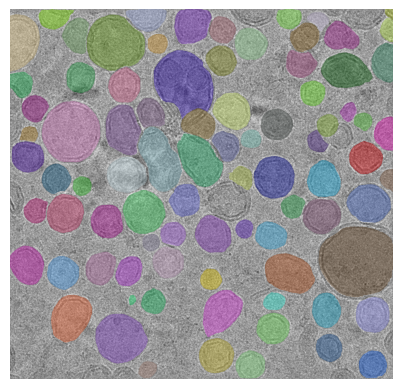

In [56]:
plt.imshow(downsample(display_micrograph, 4), cmap="Greys_r")
show_anns(filtered_masks)
plt.axis('off')

plt.savefig("EMPIAR-10426/figures/001279563948633455632_annotated.png", dpi=600, bbox_inches="tight", pad_inches=0)


plt.show()

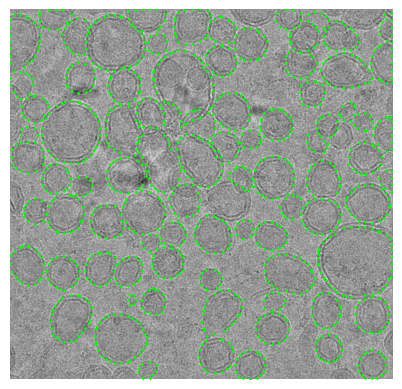

In [57]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(downsample(display_micrograph, 4), cmap="Greys_r")

# Overlay the undilated picks
ax1.scatter(x=pick_indices[1]/4,
            y=pick_indices[0]/4,
            marker='x',
            color='lime',
            s=1,
            label='original')

plt.axis('off')

plt.savefig("EMPIAR-10426/figures/001279563948633455632_picked.png", dpi=600, bbox_inches="tight", pad_inches=0)


plt.show()